In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
path="/content/drive/My Drive/MIMIC"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive/


['Multi-Filter-Residual-Convolutional-Neural-Network',
 'LAAT',
 'LAAT_Run.ipynb',
 'Process_Data',
 'MResCNN_RUN.ipynb',
 'BERT_FineTune',
 'Transformer_MCP_1.ipynb',
 'Bert-Chinese-Text-Classification-Pytorch',
 'Transformer_MCP_3.ipynb',
 'caml-mimic',
 'MResCNN_RUN_2.ipynb',
 'CALM_RUN.ipynb',
 'Transformer_MCP_7.ipynb',
 'Transformer_MCP_4.ipynb',
 'Find_MN.ipynb',
 'Transformer_MCP_2.ipynb',
 'FineTune_Visualization.ipynb',
 'mca_bert',
 'Does_Bert_Magic.ipynb',
 'Transformer_MCP_8_ClinicalBert512 + Heir.ipynb',
 'Transformer_MCP_6_ClinicalBert + Heir.ipynb',
 'Transformer_MCP_5_Bert-based-model + Heir.ipynb']

In [2]:
# import package
import pandas as pd


# 找癌症患者

In [ ]:
# read the data
diagnose_label = pd.read_csv("/content/drive/My Drive/MIMIC/Process_Data/row_data/D_ICD_DIAGNOSES.csv")
diagnose_label[:5]

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [ ]:
mn_data = [] # ICD-9 code , short title, long title
for index in range(len(diagnose_label['ROW_ID'])):
  row_info = diagnose_label.iloc[index]
  long_title = row_info[3]
  if 'Malignant neoplasm' in long_title:
    mn_data.append([row_info[1],row_info[2],row_info[3]])


In [ ]:
mn_data

In [ ]:
len(mn_data)

285

In [3]:
# load train data
train_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/train_50.csv')


,SUBJECT_ID,HADM_ID,TEXT,LABELS,length
0,7908,182396,admission date discharge date date of birth se...,584.9;287.5;45.13,105
1,11231,183363,admission date discharge date date of birth se...,401.9;96.71;272.4,106
2,3184,144347,admission date discharge date date of birth se...,530.81,117
3,24427,177066,admission date discharge date date of birth se...,96.04;V58.61;96.71;276.2,148
4,1262,183373,admission date discharge date service neurolog...,244.9;V58.61;401.9;96.71;427.31;414.01,156


In [4]:
train_data[:15]

,SUBJECT_ID,HADM_ID,TEXT,LABELS,length
0,7908,182396,admission date discharge date date of birth se...,584.9;287.5;45.13,105
1,11231,183363,admission date discharge date date of birth se...,401.9;96.71;272.4,106
2,3184,144347,admission date discharge date date of birth se...,530.81,117
3,24427,177066,admission date discharge date date of birth se...,96.04;V58.61;96.71;276.2,148
4,1262,183373,admission date discharge date service neurolog...,244.9;V58.61;401.9;96.71;427.31;414.01,156
5,16525,134157,name known lastname known firstname unit no nu...,96.04;285.9;401.9;38.91;276.1;96.72;38.93,165
6,19195,109365,admission date discharge date date of birth se...,96.72;401.9;96.6;V15.82,166
7,7861,109483,admission date discharge date date of birth se...,995.92;96.6;276.2;96.71;38.93;038.9,187
8,3019,109202,admission date discharge date date of birth se...,96.04;038.9;486;995.92;38.91;276.1;276.2;96.72...,188
9,11245,134011,admission date discharge date date of birth se...,311;96.71;38.91;96.04,190


In [5]:
train_data[-3:]

,SUBJECT_ID,HADM_ID,TEXT,LABELS,length
8063,15106,195209,admission date discharge date date of birth se...,39.61;511.9;99.04;36.15;37.22;401.9;96.6;88.56...,6922
8064,66807,166588,admission date discharge date date of birth se...,403.90;424.0;88.72;585.9;96.6;428.0;427.31;599...,7280
8065,52139,137090,admission date discharge date date of birth se...,511.9;486;401.9;995.92;287.5;38.93;038.9;272.4,7567


In [ ]:
def get_row_code(processed_code): # 给定一个预处理好的code, 得到他的原始 code
  result = ''
  processed_code_list = processed_code.split('.')
  if processed_code_list[0][0].upper() in char_list: # 如果开头就是字母
    first = 0
    for element in processed_code_list:
      if first == 0:
        result = result + element[1:]
        first = 1
      else:
        result = result + element
  else:   # 如果开头不是字母
    for element in processed_code_list:
      result = result + element
  return result

def check_mn(code_list): # 给定一个病人的ICD code list, 检查他是否患有癌症
  mn_list = []
  for code in code_list:
    for mn in mn_data:
      if code in mn[0]:
        mn_list.append( mn[0] + ' ' + mn[2] )
  return mn_list

In [ ]:
train_mn_data = []
char_list = ['A','B','C','D','E','F','G','H','I','G',
             'K','L','M','N','O','P','Q','R','S','T',
             'U','V','W','X','Y','Z']
'''
train_mn_dict = {'SUBJECT_ID':[],
         'HADM_ID':[],
         'TEXT':[],
         'LABELS':[],
         'length':[],
         'Malignant neoplasm':[]}
'''
train_mn_list = [[],    # SUBJECT_ID
                 [],    # HADM_ID
                 [],    # TEXT
                 [],    # LABELS
                 [],    # length
                 []]    # mn

In [ ]:
for index in range(len(train_data['TEXT'])):
  # 拿到一份样本的所有训练数据
  raw_info = train_data.iloc[index]
  subject_id = raw_info[0]
  hadm_id = raw_info[1]
  text = raw_info[2]
  labels= str(raw_info[3])
  length = raw_info[4]

  # 首先把label标签中间的点去掉 + 去掉开头大写字母
  label_list = []
  # print(index,labels)
  label_list_ = labels.split(';')
  #print(raw_info)
  #print(label_list_)
  for label in label_list_:
    label_list.append(get_row_code(label))
  
  # 提取出code list 里的癌症信息
  mn_list = check_mn(label_list)
  mn_labels = ''
  for mn_label in mn_list:
    mn_labels = mn_labels + ';' +mn_label 
  
  train_mn_list[0].append(subject_id)
  train_mn_list[1].append(hadm_id)
  train_mn_list[2].append(text)
  train_mn_list[3].append(labels),
  train_mn_list[4].append(length),
  train_mn_list[5].append(mn_labels)



In [ ]:
train_mn_dict = {'SUBJECT_ID':train_mn_list[0],
               'HADM_ID':train_mn_list[1],
               'TEXT':train_mn_list[2],
               'LABELS':train_mn_list[3],
               'length':train_mn_list[4],
               'Malignant Neoplasm':train_mn_list[5]}
train_mn_pd = pd.DataFrame.from_dict(train_mn_dict)

In [ ]:
train_mn_pd.to_csv("/content/drive/My Drive/MIMIC/Process_Data/processed_data/train_data_with_mn.csv")

In [ ]:
train_mn_pd = pd.read_csv("/content/drive/My Drive/MIMIC/Process_Data/processed_data/train_data_with_mn.csv")


In [ ]:
train_mn_pd[:10]

,Unnamed: 0,SUBJECT_ID,HADM_ID,TEXT,LABELS,length,Malignant Neoplasm
0,0,158,169433,admission date discharge date date of birth se...,532.40;493.20;V45.81;412;401.9;44.43,51,;1412 Malignant neoplasm of tip and lateral bo...
1,1,2896,178124,name known lastname known firstname unit no nu...,211.3;427.31;578.9;560.1;496;584.9;428.0;276.5...,55,NaN
2,2,6495,139808,admission date discharge date date of birth se...,998.59;998.32;905.4;E929.0;041.85;86.22;86.69;...,60,NaN
3,3,3564,117638,admission date discharge date service doctor l...,038.49;041.6;785.59;518.81;507.0;592.1;591;276...,68,";1591 Malignant neoplasm of spleen, not elsewh..."
4,4,7995,190945,admission date discharge date date of birth se...,440.22;492.8;401.9;714.0;39.29;88.48,74,NaN
5,5,70734,124010,name known lastname known firstname unit no nu...,852.20;410.71;805.6;285.1;816.12;E880.9;922.32...,89,NaN
6,6,11808,129572,name known lastname known firstname unit no nu...,428.0;518.81;496;401.0;250.40;583.81;96.71;96.04,92,NaN
7,7,7389,145223,admission date discharge date date of birth se...,464.51;292.0;202.80;96.04;96.71,94,NaN
8,8,18860,114195,admission date discharge date date of birth se...,414.01;424.1;401.9;272.0;36.12;35.21;36.15;39.61,102,NaN
9,9,7908,182396,admission date discharge date date of birth se...,572.2;038.49;785.52;584.9;585;571.2;578.0;070....,105,NaN


# 统计

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/train_50.csv')
test_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/test_50.csv')
dev_data = pd.read_csv('/content/drive/My Drive/MIMIC/caml-mimic/mimicdata/mimic3/dev_50.csv')
length_list = []

for index in range(len(train_data['TEXT'])):
  # 拿到一份样本的所有训练数据
  raw_info = train_data.iloc[index]
  length_list.append(raw_info[4])

for index in range(len(test_data['TEXT'])):
  # 拿到一份样本的所有训练数据
  raw_info = train_data.iloc[index]
  length_list.append(raw_info[4])

for index in range(len(dev_data['TEXT'])):
  # 拿到一份样本的所有训练数据
  raw_info = train_data.iloc[index]
  length_list.append(raw_info[4])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


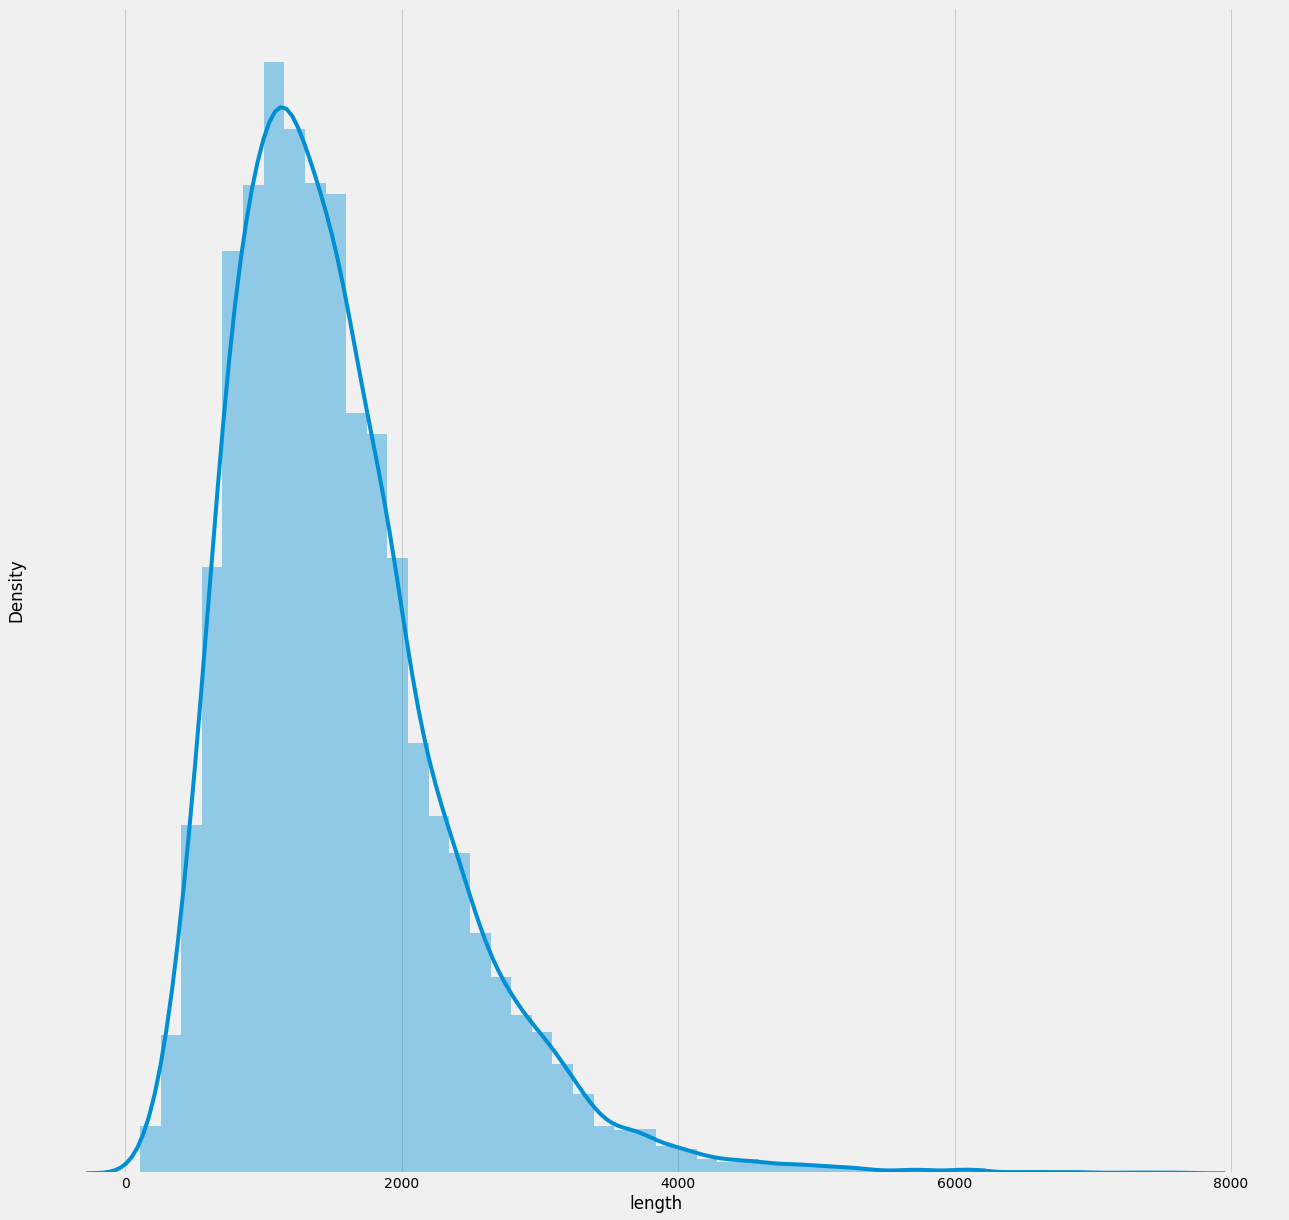

'\n# 绘制句子长度列的数量分布图\nplt.subplots(figsize=(10, 10))\nsns.countplot("length", data=train_data)\n \n# 主要关注count长度分布的纵坐标, 不需要绘制横坐标, 横坐标范围通过dist图进行查看\nplt.xticks([])\nplt.show()\n \n# 绘制dist长度分布图\nplt.subplots(figsize=(10, 10))\nsns.distplot(train_data["length"])\n \n# 主要关注dist长度分布横坐标, 不需要绘制纵坐标\nplt.yticks([])\n'

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
 
# 设置显示风格
plt.style.use('fivethirtyeight')
'''
plt.subplots(figsize=(10, 10))
# 绘制句子长度列的数量分布图
sns.countplot("length", data=train_data)
# 主要关注count长度分布的纵坐标, 不需要绘制横坐标, 横坐标范围通过dist图进行查看
plt.xticks([])
plt.show()
'''
# 绘制dist长度分布图
# plt.subplots(figsize=(10, 10))
fig,ax = plt.subplots(figsize=(20, 20))
sns.distplot(train_data["length"])
 
# 主要关注dist长度分布横坐标, 不需要绘制纵坐标
plt.yticks([])
plt.show()
fig.savefig("/content/drive/My Drive/MIMIC/BERT_FineTune/visualization/length_dis.png")
'''
# 绘制句子长度列的数量分布图
plt.subplots(figsize=(10, 10))
sns.countplot("length", data=train_data)
 
# 主要关注count长度分布的纵坐标, 不需要绘制横坐标, 横坐标范围通过dist图进行查看
plt.xticks([])
plt.show()
 
# 绘制dist长度分布图
plt.subplots(figsize=(10, 10))
sns.distplot(train_data["length"])
 
# 主要关注dist长度分布横坐标, 不需要绘制纵坐标
plt.yticks([])
'''